In [ ]:
# 09_R : 광고와 홍보

In [ ]:
# 예측 분석 모델링 실무 기법
# 소스(원저자) - http://www.ftpress.com/promotions/modeling-techniques-in-predictive-analytics-139480
# 소스(역자) - http://blog.naver.com/skk1991/220238139920

In [1]:
# Predictive Model for Los Angeles Dodgers Promotion and Attendance 

library(car)  # special functions for linear regression
library(lattice)  # graphics package

Warning message:
: package ‘car’ was built under R version 3.1.3Warning message:
: package ‘lattice’ was built under R version 3.1.2

In [2]:
# read in data and create a data frame called dodgers
dodgers <- read.csv("09_data/ad/dodgers.csv")
print(str(dodgers))  # check the structure of the data frame

'data.frame':	81 obs. of  12 variables:
 $ month      : Factor w/ 7 levels "APR","AUG","JUL",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ day        : int  10 11 12 13 14 15 23 24 25 27 ...
 $ attend     : int  56000 29729 28328 31601 46549 38359 26376 44014 26345 44807 ...
 $ day_of_week: Factor w/ 7 levels "Friday","Monday",..: 6 7 5 1 3 4 2 6 7 1 ...
 $ opponent   : Factor w/ 17 levels "Angels","Astros",..: 13 13 13 11 11 11 3 3 3 10 ...
 $ temp       : int  67 58 57 54 57 65 60 63 64 66 ...
 $ skies      : Factor w/ 2 levels "Clear ","Cloudy": 1 2 2 2 2 1 2 2 2 1 ...
 $ day_night  : Factor w/ 2 levels "Day","Night": 1 2 2 2 2 1 2 2 2 2 ...
 $ cap        : Factor w/ 2 levels "NO","YES": 1 1 1 1 1 1 1 1 1 1 ...
 $ shirt      : Factor w/ 2 levels "NO","YES": 1 1 1 1 1 1 1 1 1 1 ...
 $ fireworks  : Factor w/ 2 levels "NO","YES": 1 1 1 2 1 1 1 1 1 2 ...
 $ bobblehead : Factor w/ 2 levels "NO","YES": 1 1 1 1 1 1 1 1 1 1 ...
NULL


In [3]:
# define an ordered day-of-week variable 
# for plots and data summaries
dodgers$ordered_day_of_week <- with(data=dodgers,
  ifelse ((day_of_week == "Monday"),1,
  ifelse ((day_of_week == "Tuesday"),2,
  ifelse ((day_of_week == "Wednesday"),3,
  ifelse ((day_of_week == "Thursday"),4,
  ifelse ((day_of_week == "Friday"),5,
  ifelse ((day_of_week == "Saturday"),6,7)))))))
dodgers$ordered_day_of_week <- factor(dodgers$ordered_day_of_week, levels=1:7,
labels=c("Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"))

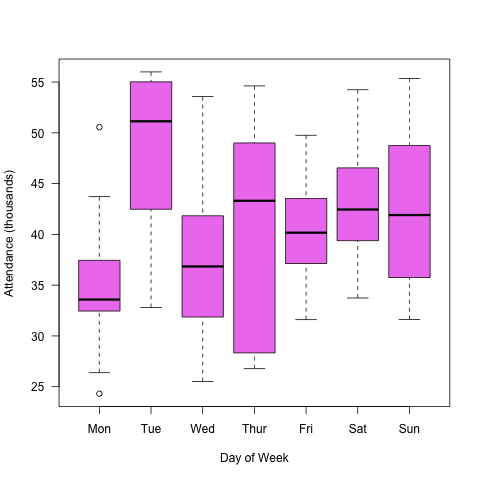

In [4]:
# exploratory data analysis with standard graphics: attendance by day of week
with(data=dodgers,plot(ordered_day_of_week, attend/1000, 
xlab = "Day of Week", ylab = "Attendance (thousands)", 
col = "violet", las = 1))

In [5]:
# when do the Dodgers use bobblehead promotions
with(dodgers, table(bobblehead,ordered_day_of_week)) # bobbleheads on Tuesday

          ordered_day_of_week
bobblehead Mon Tue Wed Thur Fri Sat Sun
       NO   12   7  12    3  13  11  12
       YES   0   6   0    2   0   2   1

In [6]:
# define an ordered month variable 
# for plots and data summaries
dodgers$ordered_month <- with(data=dodgers,
  ifelse ((month == "APR"),4,
  ifelse ((month == "MAY"),5,
  ifelse ((month == "JUN"),6,
  ifelse ((month == "JUL"),7,
  ifelse ((month == "AUG"),8,
  ifelse ((month == "SEP"),9,10)))))))
dodgers$ordered_month <- factor(dodgers$ordered_month, levels=4:10,
labels = c("April", "May", "June", "July", "Aug", "Sept", "Oct"))

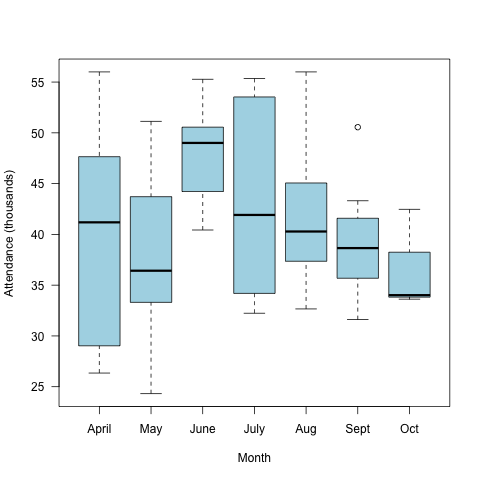

In [7]:
# exploratory data analysis with standard R graphics: attendance by month 
with(data=dodgers,plot(ordered_month,attend/1000, xlab = "Month", 
ylab = "Attendance (thousands)", col = "light blue", las = 1))

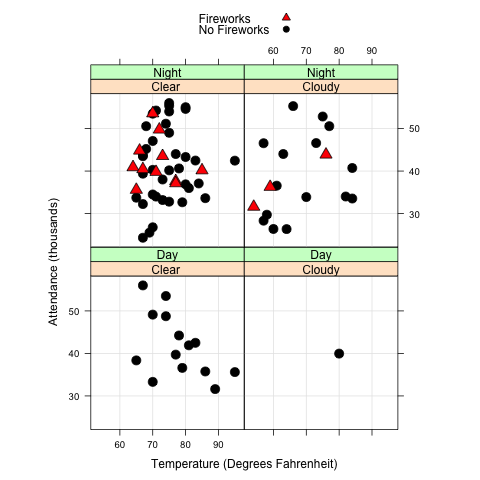

In [8]:
# exploratory data analysis displaying many variables
# looking at attendance and conditioning on day/night
# the skies and whether or not fireworks are displayed
library(lattice) # used for plotting 
# let us prepare a graphical summary of the dodgers data
group.labels <- c("No Fireworks","Fireworks")
group.symbols <- c(21,24)
group.colors <- c("black","black") 
group.fill <- c("black","red")
xyplot(attend/1000 ~ temp | skies + day_night, 
    data = dodgers, groups = fireworks, pch = group.symbols, 
    aspect = 1, cex = 1.5, col = group.colors, fill = group.fill,
    layout = c(2, 2), type = c("p","g"),
    strip=strip.custom(strip.levels=TRUE,strip.names=FALSE, style=1),
    xlab = "Temperature (Degrees Fahrenheit)", 
    ylab = "Attendance (thousands)",
    key = list(space = "top", 
        text = list(rev(group.labels),col = rev(group.colors)),
        points = list(pch = rev(group.symbols), col = rev(group.colors),
        fill = rev(group.fill))))

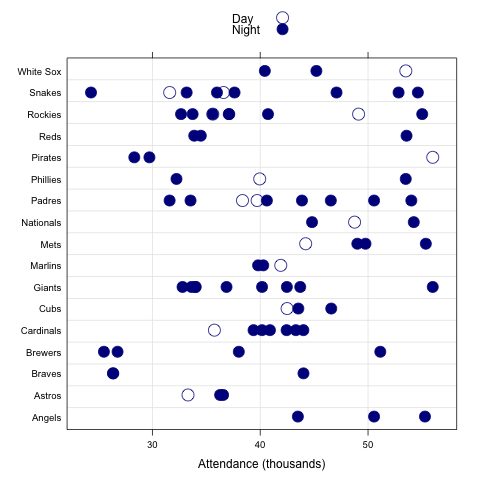

In [9]:
# attendance by opponent and day/night game
group.labels <- c("Day","Night")
group.symbols <- c(1,20)
group.symbols.size <- c(2,2.75)
bwplot(opponent ~ attend/1000, data = dodgers, groups = day_night, 
    xlab = "Attendance (thousands)",
    panel = function(x, y, groups, subscripts, ...) 
       {panel.grid(h = (length(levels(dodgers$opponent)) - 1), v = -1)
        panel.stripplot(x, y, groups = groups, subscripts = subscripts, 
        cex = group.symbols.size, pch = group.symbols, col = "darkblue")
       },
    key = list(space = "top", 
    text = list(group.labels,col = "black"),
    points = list(pch = group.symbols, cex = group.symbols.size, 
    col = "darkblue")))

In [10]:
# specify a simple model with bobblehead entered last
my.model <- {attend ~ ordered_month + ordered_day_of_week + bobblehead}

In [11]:
# employ a training-and-test regimen
set.seed(1234) # set seed for repeatability of training-and-test split
training_test <- c(rep(1,length=trunc((2/3)*nrow(dodgers))),
rep(2,length=(nrow(dodgers) - trunc((2/3)*nrow(dodgers)))))
dodgers$training_test <- sample(training_test) # random permutation 
dodgers$training_test <- factor(dodgers$training_test, 
  levels=c(1,2), labels=c("TRAIN","TEST"))
dodgers.train <- subset(dodgers, training_test == "TRAIN")
print(str(dodgers.train)) # check training data frame
dodgers.test <- subset(dodgers, training_test == "TEST")
print(str(dodgers.test)) # check test data frame

'data.frame':	54 obs. of  15 variables:
 $ month              : Factor w/ 7 levels "APR","AUG","JUL",..: 1 1 1 1 1 1 1 5 5 5 ...
 $ day                : int  10 11 12 23 24 27 29 7 12 14 ...
 $ attend             : int  56000 29729 28328 26376 44014 44807 48753 43713 33735 24312 ...
 $ day_of_week        : Factor w/ 7 levels "Friday","Monday",..: 6 7 5 2 6 1 4 2 3 2 ...
 $ opponent           : Factor w/ 17 levels "Angels","Astros",..: 13 13 13 3 3 10 10 7 15 16 ...
 $ temp               : int  67 58 57 60 63 66 74 67 65 67 ...
 $ skies              : Factor w/ 2 levels "Clear ","Cloudy": 1 2 2 2 2 1 1 1 1 1 ...
 $ day_night          : Factor w/ 2 levels "Day","Night": 1 2 2 2 2 2 1 2 2 2 ...
 $ cap                : Factor w/ 2 levels "NO","YES": 1 1 1 1 1 1 1 1 1 1 ...
 $ shirt              : Factor w/ 2 levels "NO","YES": 1 1 1 1 1 1 2 1 1 1 ...
 $ fireworks          : Factor w/ 2 levels "NO","YES": 1 1 1 1 1 2 1 1 1 1 ...
 $ bobblehead         : Factor w/ 2 levels "NO","YES": 1 1 1 1

In [12]:
# fit the model to the training set
train.model.fit <- lm(my.model, data = dodgers.train)
# obtain predictions from the training set
dodgers.train$predict_attend <- predict(train.model.fit) 

In [13]:
# evaluate the fitted model on the test set
dodgers.test$predict_attend <- predict(train.model.fit, 
  newdata = dodgers.test)

In [14]:
# compute the proportion of response variance
# accounted for when predicting out-of-sample
cat("\n","Proportion of Test Set Variance Accounted for: ",
round((with(dodgers.test,cor(attend,predict_attend)^2)),
  digits=3),"\n",sep="")


Proportion of Test Set Variance Accounted for: 0.453


In [15]:
# merge the training and test sets for plotting
dodgers.plotting.frame <- rbind(dodgers.train,dodgers.test)

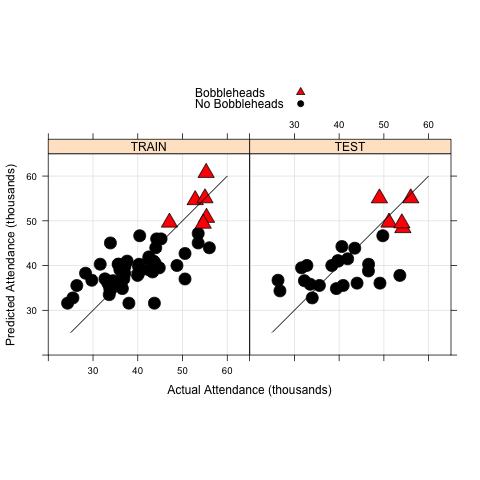

In [16]:
# generate predictive modeling visual for management
group.labels <- c("No Bobbleheads","Bobbleheads")
group.symbols <- c(21,24)
group.colors <- c("black","black") 
group.fill <- c("black","red")  
xyplot(predict_attend/1000 ~ attend/1000 | training_test, 
       data = dodgers.plotting.frame, groups = bobblehead, cex = 2,
       pch = group.symbols, col = group.colors, fill = group.fill, 
       layout = c(2, 1), xlim = c(20,65), ylim = c(20,65), 
       aspect=1, type = c("p","g"),
       panel=function(x,y, ...)
            {panel.xyplot(x,y,...)
             panel.segments(25,25,60,60,col="black",cex=2)
            },
       strip=function(...) strip.default(..., style=1),
       xlab = "Actual Attendance (thousands)", 
       ylab = "Predicted Attendance (thousands)",
       key = list(space = "top", 
              text = list(rev(group.labels),col = rev(group.colors)),
              points = list(pch = rev(group.symbols), 
              col = rev(group.colors),
              fill = rev(group.fill))))

In [17]:
# use the full data set to obtain an estimate of the increase in
# attendance due to bobbleheads, controlling for other factors 
my.model.fit <- lm(my.model, data = dodgers)  # use all available data
print(summary(my.model.fit))
# tests statistical significance of the bobblehead promotion
# type I anova computes sums of squares for sequential tests
print(anova(my.model.fit))


Call:
lm(formula = my.model, data = dodgers)

Residuals:
     Min       1Q   Median       3Q      Max 
-10786.5  -3628.1   -516.1   2230.2  14351.0 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             33909.16    2521.81  13.446  < 2e-16 ***
ordered_monthMay        -2385.62    2291.22  -1.041  0.30152    
ordered_monthJune        7163.23    2732.72   2.621  0.01083 *  
ordered_monthJuly        2849.83    2578.60   1.105  0.27303    
ordered_monthAug         2377.92    2402.91   0.990  0.32593    
ordered_monthSept          29.03    2521.25   0.012  0.99085    
ordered_monthOct         -662.67    4046.45  -0.164  0.87041    
ordered_day_of_weekTue   7911.49    2702.21   2.928  0.00466 ** 
ordered_day_of_weekWed   2460.02    2514.03   0.979  0.33134    
ordered_day_of_weekThur   775.36    3486.15   0.222  0.82467    
ordered_day_of_weekFri   4883.82    2504.65   1.950  0.05537 .  
ordered_day_of_weekSat   6372.06    2552.08   2.497  0.

In [18]:
cat("\n","Estimated Effect of Bobblehead Promotion on Attendance: ",
round(my.model.fit$coefficients[length(my.model.fit$coefficients)],
digits = 0),"\n",sep="")


Estimated Effect of Bobblehead Promotion on Attendance: 10715


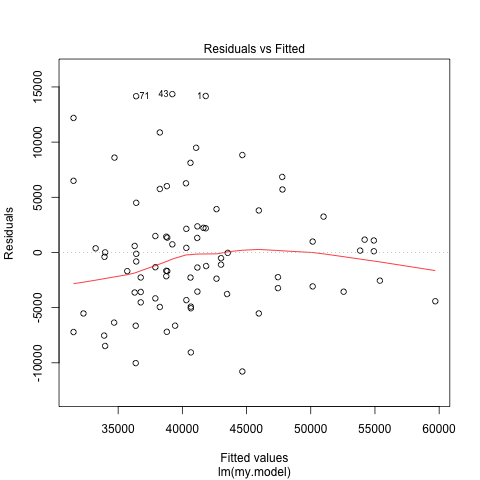

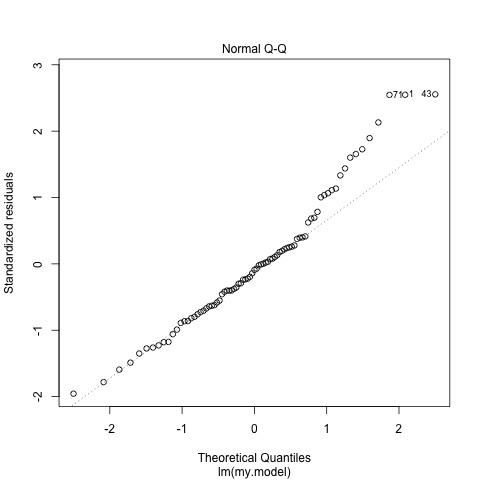

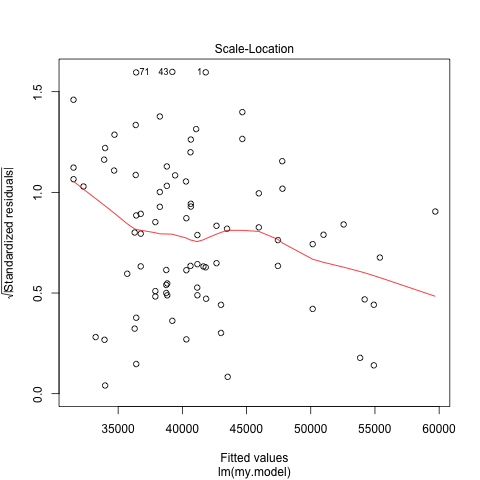

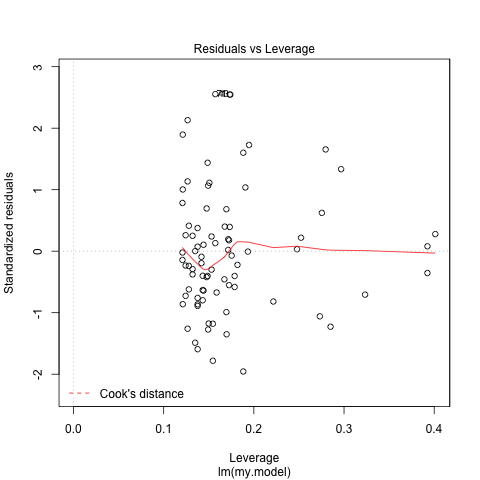

In [19]:
# standard graphics provide diagnostic plots
plot(my.model.fit)

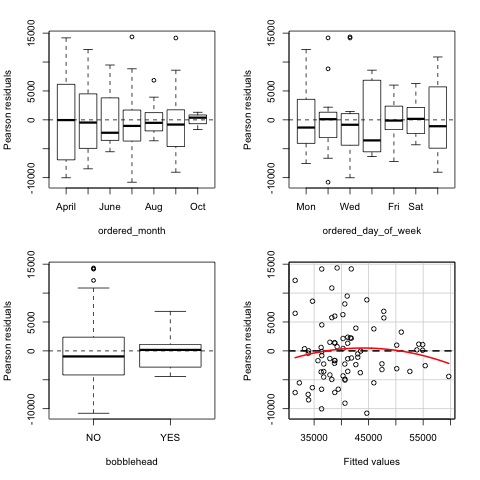

                    Test stat Pr(>|t|)
ordered_month              NA       NA
ordered_day_of_week        NA       NA
bobblehead                 NA       NA
Tukey test             -1.123    0.261

Warning message:
In mmps(...): Interactions and/or factors skipped

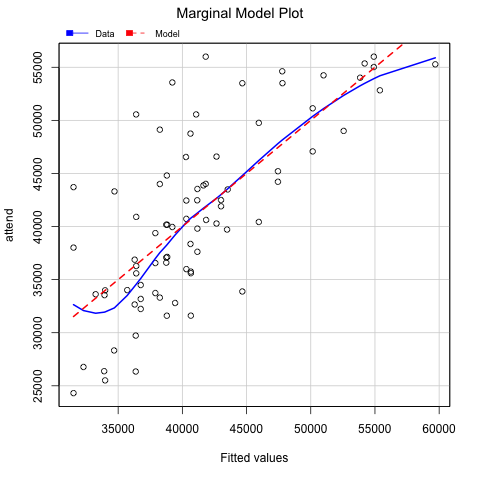


No Studentized residuals with Bonferonni p < 0.05
Largest |rstudent|:
   rstudent unadjusted p-value Bonferonni p
43 2.668406          0.0095805      0.77602


In [20]:
# additional model diagnostics drawn from the car package
library(car)
residualPlots(my.model.fit)
marginalModelPlots(my.model.fit)
print(outlierTest(my.model.fit))

In [21]:
# additional work for the student
# examine regression diagnositics
# examine other linear predictors... other explanatory variables
# will transformations of variables help?